In [456]:
import tensorflow as tf
import os
import cv2
import imghdr
import numpy as np
from matplotlib import pyplot as plt

In [254]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [256]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [258]:
data_dir = 'data' 

In [260]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [262]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

In [263]:
tf.data.Dataset??

Init signature: tf.data.Dataset(variant_tensor)
Source:        
@tf_export("data.Dataset", v1=[])
@six.add_metaclass(abc.ABCMeta)
class DatasetV2(collections_abc.Iterable, tracking_base.Trackable,
                composite_tensor.CompositeTensor):
  """Represents a potentially large set of elements.

  The `tf.data.Dataset` API supports writing descriptive and efficient input
  pipelines. `Dataset` usage follows a common pattern:

  1. Create a source dataset from your input data.
  2. Apply dataset transformations to preprocess the data.
  3. Iterate over the dataset and process the elements.

  Iteration happens in a streaming fashion, so the full dataset does not need to
  fit into memory.

  Source Datasets:

  The simplest way to create a dataset is to create it from a python `list`:

  >>> dataset = tf.data.Dataset.from_tensor_slices([1, 2, 3])
  >>> for element in dataset:
  ...   print(element)
  tf.Tensor(1, shape=(), dtype=int32)
  tf.Tensor(2, shape=(), dtype=int32)
  tf.Ten

In [364]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 171 files belonging to 2 classes.


In [366]:
data_iterator = data.as_numpy_iterator()

In [368]:
batch = data_iterator.next()

In [369]:
# Image represented as numpy arrays
batch[0].shape

(32, 256, 256, 3)

In [370]:
#Class 1 = sad
#CLass 0 = happy
batch[1]

array([0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1])

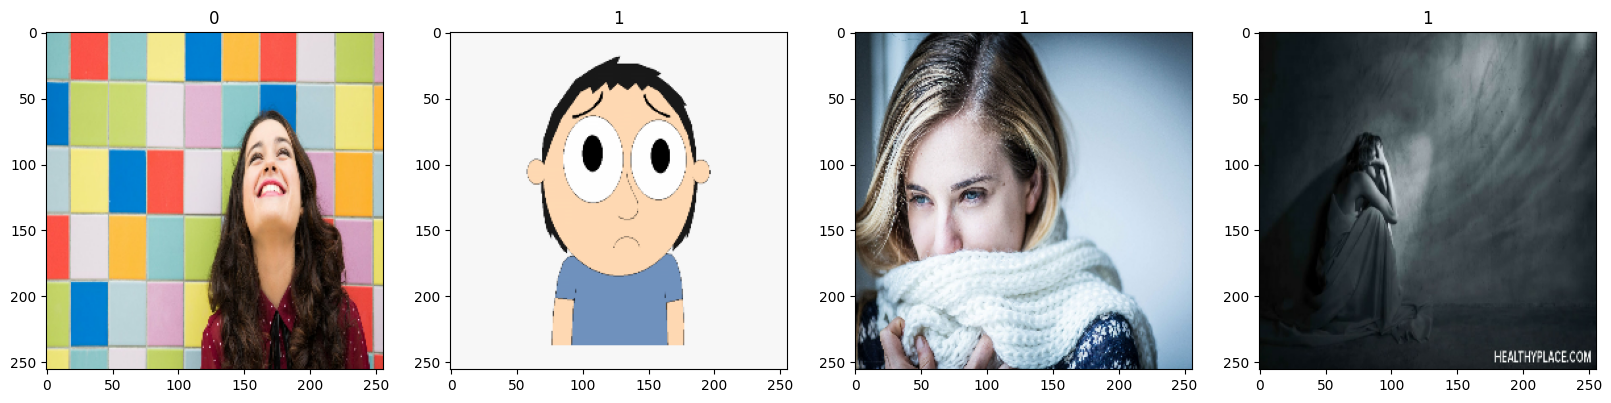

In [374]:
fig,ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [376]:
#Preprocessing

In [378]:
data = data.map(lambda x,y:(x/255,y)) #Allow performing the transformation in that pipeline

In [380]:
scaled_iterator = data.as_numpy_iterator()

In [382]:
batch = scaled_iterator.next()

In [383]:
batch[0].max()

1.0

In [386]:
#split data

In [388]:
len(data)

6

In [390]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)+1

In [392]:
train_size + val_size + test_size 

6

In [394]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [396]:
len(test)

1

In [398]:
#Modeling

In [400]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [402]:
model = Sequential()

In [404]:
model.add(Conv2D(16,(3,3),1,activation='relu',input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32,(3,3),1,activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16,(3,3),1,activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

In [406]:
#adam is one of the optimizer

In [408]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(),metrics=['accuracy'])

In [410]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 127, 127, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 30, 30, 16)      

In [412]:
#Training

In [414]:
logdir='log'

In [416]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [418]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
4/4 [==============================] - 2s 235ms/step - loss: 1.2899 - accuracy: 0.5391 - val_loss: 0.8834 - val_accuracy: 0.3750
Epoch 2/20
4/4 [==============================] - 1s 206ms/step - loss: 0.7062 - accuracy: 0.5156 - val_loss: 0.9024 - val_accuracy: 0.4688
Epoch 3/20
4/4 [==============================] - 1s 216ms/step - loss: 0.6467 - accuracy: 0.6172 - val_loss: 0.5730 - val_accuracy: 0.5938
Epoch 4/20
4/4 [==============================] - 1s 225ms/step - loss: 0.6261 - accuracy: 0.5859 - val_loss: 0.5684 - val_accuracy: 0.8125
Epoch 5/20
4/4 [==============================] - 1s 241ms/step - loss: 0.5946 - accuracy: 0.7188 - val_loss: 0.5491 - val_accuracy: 0.6875
Epoch 6/20
4/4 [==============================] - 1s 212ms/step - loss: 0.5502 - accuracy: 0.7656 - val_loss: 0.4357 - val_accuracy: 0.8438
Epoch 7/20
4/4 [==============================] - 1s 211ms/step - loss: 0.4528 - accuracy: 0.7734 - val_loss: 0.3933 - val_accuracy: 0.8438
Epoch 8/20
4/4 [====

In [419]:
hist.history

{'loss': [1.289858102798462,
  0.7062110304832458,
  0.6467110514640808,
  0.6261453628540039,
  0.5946191549301147,
  0.5501881241798401,
  0.4527621567249298,
  0.37766748666763306,
  0.31842923164367676,
  0.25275230407714844,
  0.21602654457092285,
  0.11588235199451447,
  0.11388097703456879,
  0.07453182339668274,
  0.05310468748211861,
  0.0369630828499794,
  0.0342891626060009,
  0.023739321157336235,
  0.023122606799006462,
  0.014001909643411636],
 'accuracy': [0.5390625,
  0.515625,
  0.6171875,
  0.5859375,
  0.71875,
  0.765625,
  0.7734375,
  0.7890625,
  0.859375,
  0.921875,
  0.8984375,
  0.9921875,
  0.953125,
  0.9765625,
  0.9921875,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0],
 'val_loss': [0.8834216594696045,
  0.9023874402046204,
  0.5729772448539734,
  0.5683837532997131,
  0.5490913391113281,
  0.4356961250305176,
  0.3932839035987854,
  0.33722779154777527,
  0.22495916485786438,
  0.2275383025407791,
  0.2295624017715454,
  0.19596415758132935,
  0.04757610708475113,


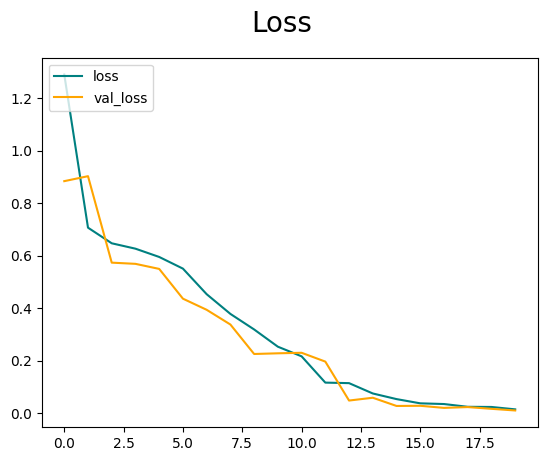

In [424]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [426]:
#if loss going done but val_loss going up, probably the model is overfitting

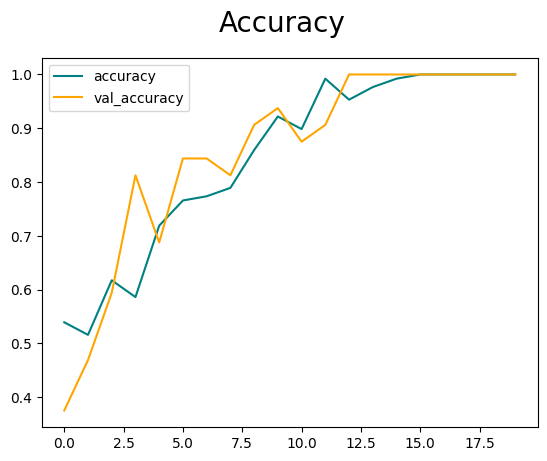

In [428]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [430]:
#Evaluate

In [432]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [434]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [436]:
len(test)

1

In [440]:
for batch in test.as_numpy_iterator():
    X,y = batch
    yhat = model.predict(X)
    pre.update_state(y,yhat)
    re.update_state(y,yhat)
    acc.update_state(y,yhat)

1/1 [==============================] - 0s 75ms/step


In [442]:
print(f'Precision:{pre.result().numpy()},Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision:1.0,Recall:1.0, Accuracy:1.0


In [484]:
#test

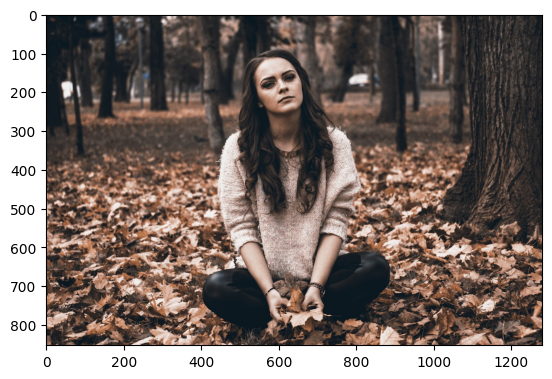

In [486]:
img = cv2.imread('sad1.jpg')
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.show()

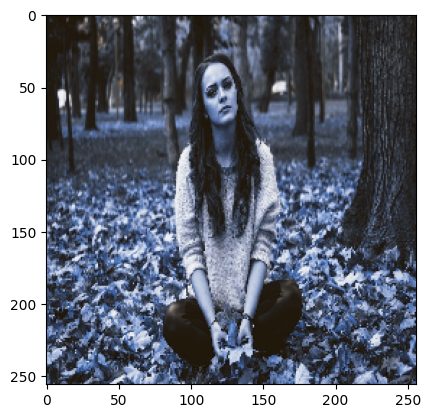

In [488]:
resize = tf.image.resize(img,(256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [490]:
yhat = model.predict(np.expand_dims(resize/255,0))
#put the yhat into an array (256,256,3) to (1,256,256,3)

1/1 [==============================] - 0s 23ms/step


In [492]:
yhat

array([[0.99212945]], dtype=float32)

In [494]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy') 

Predicted class is Sad


In [482]:
#save model

In [497]:
from tensorflow.keras.models import load_model

In [500]:
model.save(os.path.join('model','happysadmodel.h5'))

In [509]:
new_model = load_model(os.path.join('model','happysadmodel.h5'))

In [510]:
yhatnew = new_model.predict(np.expand_dims(resize/255,0))

1/1 [==============================] - 0s 42ms/step


In [515]:
if yhatnew > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Sad
